# Random Forest Regression model for Time Series predict

The purpose of this kernel is to evaluate the **possibility of using regressive classification algorithms as a way to predict time series lags.** For this, a quick prediction was made with Auto-ARIMA, and after finding the difficulty of this model to achieve good results, I used the techniques of Random Forest Regression, using features such as lags, diff and rolling mean.

In [2]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## Import Data

In [3]:
arqs = os.listdir("FROTO")


In [6]:
import pandas as pd

# İlk dosyayı okuyarak başlangıç DataFrame'i oluşturun
data = pd.DataFrame(pd.read_excel("FROTO/" + arqs[0])['Date'])

# Diğer dosyaları işleyerek veriyi birleştirin
for a in arqs:
    name = a.replace('FROTO_30Dk.xlsx', '')
    arq = pd.DataFrame(pd.read_excel("FROTO/" + a)["Open"])
    arq.rename(columns={'Open': name}, inplace=True)
    data = pd.concat([data, arq], axis=1, join='outer')

# Sonuç DataFrame'i kontrol edin
print(data)


            Date  FROTO_Günlük_EMA(5,14).xlsx  FROTO_60Dk.xlsx  \
0     18.04.2002                         0.69           100.96   
1     19.04.2002                         0.70           101.13   
2     22.04.2002                         0.71           101.05   
3     24.04.2002                         0.69           101.13   
4     25.04.2002                         0.68           101.87   
...          ...                          ...              ...   
7906         NaN                          NaN          1126.00   
7907         NaN                          NaN          1128.00   
7908         NaN                          NaN          1131.00   
7909         NaN                          NaN          1134.00   
7910         NaN                          NaN          1128.00   

      FROTO_240Dk_EMA(5,14).xlsx  FROTO_Günlük.xlsx           \
0                         100.72               0.69   991.48   
1                         100.96               0.70   996.31   
2              

## Visualizing Data

It can be seen that the series are very volatile due to reduced operations and little correlation with predictive ability. This scenario requires more sophisticated predictive models with new variables.

### Line chart

In [11]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,1], name = data.iloc[:,1].name, line = dict(color = '#17BECF'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,2], name = data.iloc[:,2].name, line = dict(color = '#CF1717'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,3], name = data.iloc[:,3].name, line = dict(color = '#AACF17'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,4], name = data.iloc[:,4].name, line = dict(color = '#17CF29'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,5], name = data.iloc[:,5].name, line = dict(color = '#1742CF'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,6], name = data.iloc[:,6].name, line = dict(color = '#B017CF'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,7], name = data.iloc[:,7].name, line = dict(color = '#CF1773'), opacity = 0.8))
fig.update_layout(title_text=data.iloc[:,1].name+', '+data.iloc[:,2].name+', '+data.iloc[:,3].name+', '+data.iloc[:,4].name+', '+data.iloc[:,5].name+', '+
                 data.iloc[:,6].name+', '+data.iloc[:,7].name)
fig.show()

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,1], name = data.iloc[:,1].name, line = dict(color = '#17BECF'), opacity = 0.8))
fig.add_trace(go.Scatter(x=data.Date, y=data.iloc[:,2], name = data.iloc[:,2].name, line = dict(color = '#CF1717'), opacity = 0.8))

fig.update_layout(title_text=data.iloc[:,1].name+', '+data.iloc[:,2].name)
fig.show()

### Correlation

In [17]:
variations=((data.select_dtypes(float)/data.select_dtypes(float).shift(1))-1)
variations=variations.dropna()

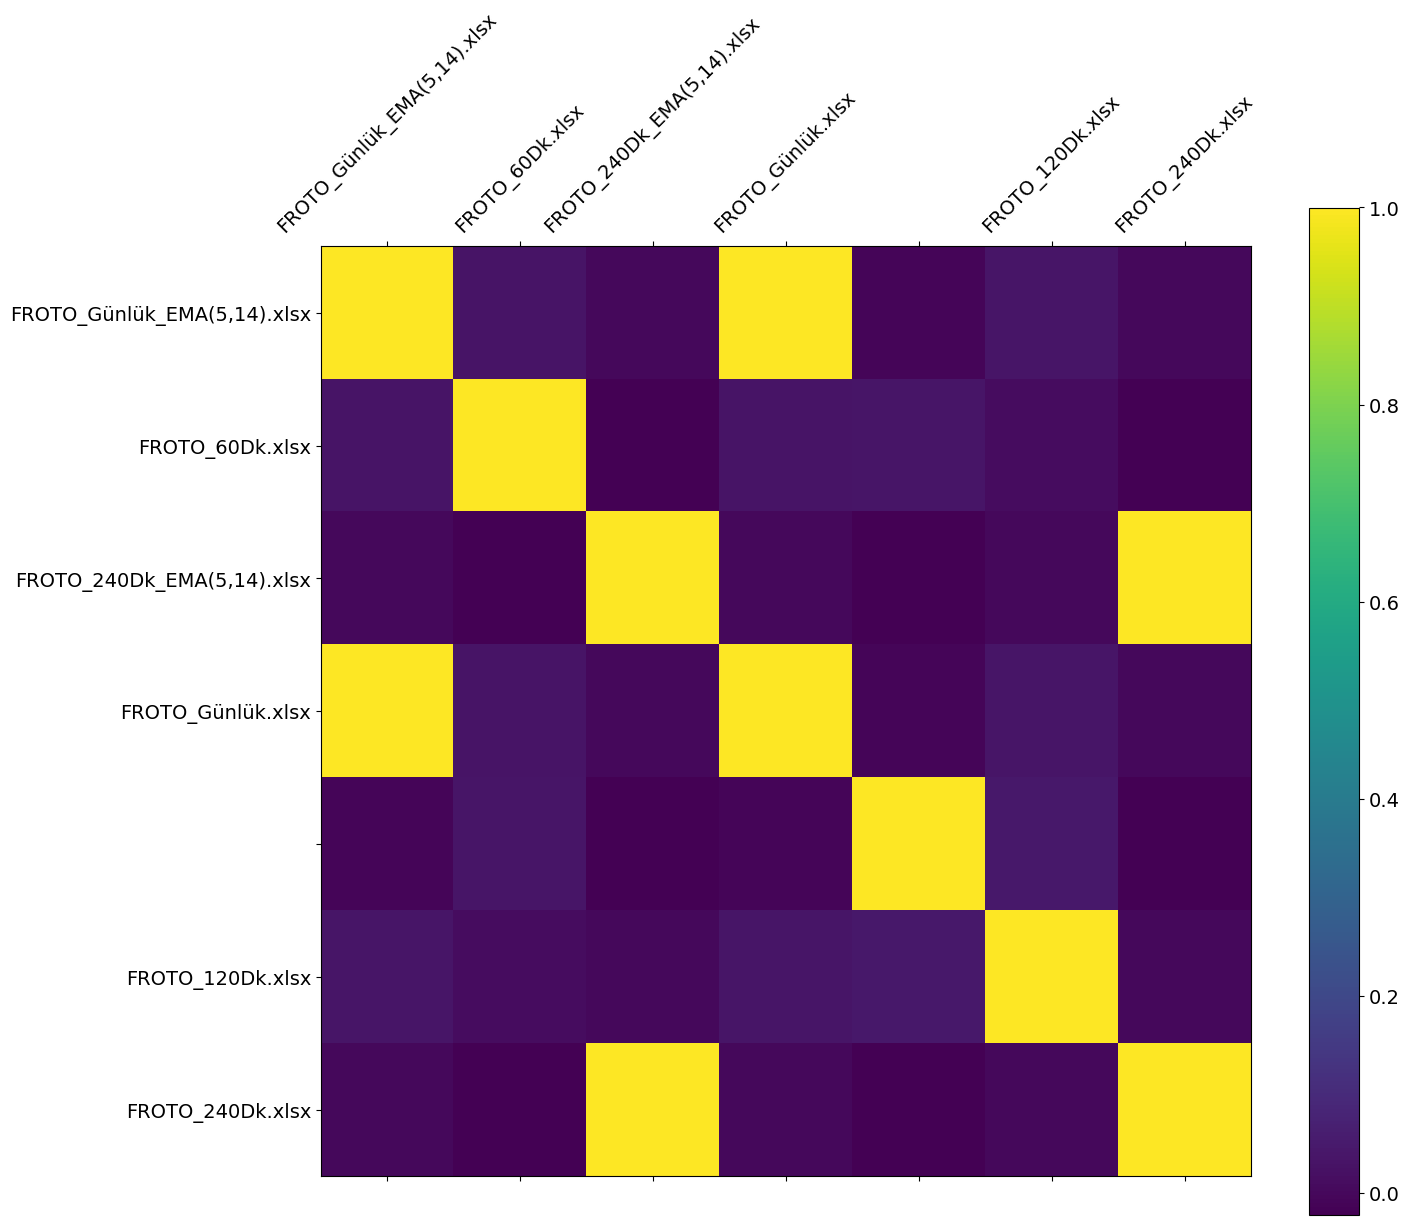

In [18]:
f = plt.figure(figsize=(15, 13))
plt.matshow(variations.corr(), fignum=f.number)
plt.xticks(range(variations.shape[1]), variations.columns, fontsize=14, rotation=45)
plt.yticks(range(variations.shape[1]), variations.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14);

## Stationary test, diff and auto-arima[](http://)

In [19]:
data=data.set_index("Date")
data=data.dropna()
columns = data.columns

### Stationary test

In [20]:
data=data.dropna()
index=data.index
columns = data.columns
df_stats = pd.DataFrame(columns=['P-value'], index=columns)
for col in columns:
  dftest = adfuller(data[col], autolag='AIC')
  df_stats.loc[col]=dftest[1]

In [21]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Bar(
            x=df_stats.index, y=df_stats['P-value'],
            text=df_stats['P-value'],
            textposition='auto',)])

fig.show()

### Diff

In [22]:
data_diff = pd.DataFrame(columns=columns)
data_diff['Date']=data.index
for col in columns:
  data_diff[col] = pd.DataFrame(np.diff(data[col]))

data_diff=data_diff.dropna()
for col in columns:
  dftest = adfuller(data_diff[col], autolag='AIC')
  df_stats.loc[col]=dftest[1]

In [23]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Bar(
            x=df_stats.index, y=df_stats['P-value'],
            text=df_stats['P-value'],
            textposition='auto',)])

fig.show()

In [24]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_diff.Date, y=data_diff.iloc[:,1], name = data_diff.iloc[:,1].name, line = dict(color = '#17BECF'), opacity = 0.8))

### Auto-ARIMA

In [4]:
!pip install pmdarima

In [5]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(data_diff["AAPL"], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

NameError: name 'data_diff' is not defined

In [ ]:
data_diff=data_diff.set_index('Date')
train = data_diff["AAPL"].loc[data_diff.index < '2016-12-31']
test = data_diff["AAPL"].loc['2016-12-31':'2017-01-31']
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=20)
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=["AAPL"])

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test.values, name = "AAPL - Original Serie", line = dict(color = '#17BECF'), opacity = 0.8))
fig.add_trace(go.Scatter(x=future_forecast.index, y=future_forecast["AAPL"], name = "AAPL - Forecasting Serie", line = dict(color = '#CF1717'), opacity = 0.8))
fig.show()

## Random Forest Regression 

### Attributes Selections

It is observed that the lags, differentiated series and rolling mean are necessary features to improve the model. Seasonality does not have efficient predictive capacity.

#### Lags

In [ ]:
lags = pd.DataFrame()
for i in range(10,0,-1):
    lags['t-'+str(i)] = data_diff["AAPL"].shift(i)
    lags['t'] = data_diff['AAPL'].values
lags = lags[13:]

from sklearn.ensemble import RandomForestRegressor
array = lags.values
X = array[:,0:-1]
y = array[:,-1]
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

In [ ]:
import plotly.graph_objects as go
names = lags.columns
fig = go.Figure(data=[go.Bar(
            x=lags.columns, y=model.feature_importances_,
            text=model.feature_importances_,
            textposition='auto',)])

fig.show()

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 4)
fit = rfe.fit(X, y)
names = lags.columns
columns=[]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        columns.append(names[i])

print("Columns with predictive power:", columns )

We will therefore use 4 previous lags for as features for our model.

#### Seasonal

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
result = seasonal_decompose(data, model='additive', freq=1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal.values, mode='lines', name='Seasonal - AAPL'))

The series do not have seasonality that could be used with predictive power.

#### Rolling Mean

In [ ]:
columns=data.columns
data_mean=pd.DataFrame(columns=columns)
for col in columns:
    data_mean[col] = data[col].rolling(window = 80).mean()
data_mean = data_mean.dropna()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['AAPL'], mode='lines', name='AAPL'))
fig.add_trace(go.Scatter(x=data.index, y=data_mean['AAPL'], mode='lines', name='AAPL - Rolling Mean'))

### Random Forest Model

In [ ]:
#pre-processing data
df_forecasting=pd.DataFrame(data["AAPL"])
df_forecasting["AAPL_diff"] = df_forecasting["AAPL"].diff()
for i in range(4,0,-1):
    df_forecasting['t-'+str(i)] = df_forecasting["AAPL"].shift(i)
df_forecasting=df_forecasting.dropna()
df_forecasting["AAPL_rolling"] = df_forecasting["AAPL"].rolling(window = 80).mean()
df_forecasting= df_forecasting.dropna()

In [ ]:
#model
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
x=df_forecasting.iloc[:,1:]
y=df_forecasting.iloc[:,0]
x_train, x_valid = x.loc[x.index < '2017-10-01'], x.loc[x.index >= '2017-10-01']
y_train, y_valid = y.loc[y.index < '2017-10-01'], y.loc[y.index >= '2017-10-01']
mdl = rf=RandomForestRegressor(n_estimators=100)
mdl.fit(x_train, y_train)
pred=mdl.predict(x_valid)
mean_absolute_error(y_valid, pred)
pred=pd.Series(pred, index=y_valid.index)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_valid.index, y=y_valid.values, mode='lines', name='AAPL'))
fig.add_trace(go.Scatter(x=pred.index, y=pred.values, mode='lines', name='AAPL - Forecasting'))

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.loc[y_train.index > '2017-07-01'].index, y=y_train.loc[y_train.index > '2017-07-01'].values, mode='lines', name='AAPL before'))
fig.add_trace(go.Scatter(x=y_valid.index, y=y_valid.values, mode='lines', name='AAPL observed'))
fig.add_trace(go.Scatter(x=pred.index, y=pred.values, mode='lines', name='AAPL - Forecasting'))

In [ ]:
from sklearn.metrics import mean_squared_log_error
var_menor_erro = None
valor_menor_erro = 1000.

for var in x_train.columns:
    mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=500)
    mdl.fit(x_train[[var]], y_train)
    p = mdl.predict(x_valid[[var]])
    erro = np.sqrt(mean_squared_log_error(y_valid, p)) * 100
    print("Variável: {} - Erro: {:.4f}\n".format(var, erro))
    
    if erro < valor_menor_erro:
        var_menor_erro = var
        valor_menor_erro = erro
        
print("Var: {} - Error: {:.4f}\n".format(var_menor_erro, valor_menor_erro))

### Random Forest for 30 assets 

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
score=[]
mse=[]
predict=pd.DataFrame()
for c in data.columns:
  #pre-processing data
  df_forecasting=pd.DataFrame(data[c])
  df_forecasting["var_diff"] = df_forecasting[c].diff()
  for i in range(4,0,-1):
      df_forecasting['t-'+str(i)] = df_forecasting[c].shift(i)
  df_forecasting=df_forecasting.dropna()
  df_forecasting["var_rolling"] = df_forecasting[c].rolling(window = 80).mean()
  df_forecasting= df_forecasting.dropna()
  #modeling 
  x=df_forecasting.iloc[:,1:]
  y=df_forecasting.iloc[:,0]
  x_train, x_valid = x.loc[x.index < '2017-10-01'], x.loc[x.index >= '2017-10-01']
  y_train, y_valid = y.loc[y.index < '2017-10-01'], y.loc[y.index >= '2017-10-01']
  mdl = RandomForestRegressor(n_estimators=100)
  mdl.fit(x_train, y_train)
  pred=mdl.predict(x_valid)
  predict[c+"_valid"]=y_valid.values
  predict[c+"_predict"]=pred
  m=mean_absolute_error(y_valid, pred)
  s=mdl.score(x_valid, y_valid)
  score.append([c, s])
  mse.append([c, m])

predict=predict.set_index(y_valid.index)
pred=pd.Series(pred, index=y_valid.index)
score=pd.DataFrame(score, columns=["Asset", "Score"])
score=score.set_index("Asset")

#### Model performance

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Bar(
            x=score.index, y=score["Score"],
            text=score["Score"],
            textposition='auto',)])

fig.show()

In [ ]:
print("Max is:", score[score["Score"]==score.max()[0]].index)
print("Min is:", score[score["Score"]==score.min()[0]].index)

#### The worst perform: INTC 

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data["INTC"].loc['2017-07-01':'2017-10-01'].index, y=data["INTC"].loc['2017-07-01':'2017-10-01'].values, mode='lines', name='INTC observed'))
fig.add_trace(go.Scatter(x=predict["INTC_valid"].index, y=predict["INTC_valid"].values, mode='lines', name='INTC observed'))
fig.add_trace(go.Scatter(x=predict["INTC_predict"].index, y=predict["INTC_predict"].values, mode='lines', name='INTC - Forecasting'))

#### The best perform: VZ

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data["VZ"].loc['2017-07-01':'2017-10-01'].index, y=data["VZ"].loc['2017-07-01':'2017-10-01'].values, mode='lines', name='VZ observed'))
fig.add_trace(go.Scatter(x=predict["VZ_valid"].index, y=predict["VZ_valid"].values, mode='lines', name='VZ observed'))
fig.add_trace(go.Scatter(x=predict["VZ_predict"].index, y=predict["VZ_predict"].values, mode='lines', name='VZ - Forecasting'))

## Conclusion

We have adopted a comparative analysis between the traditional ARIMA technique and another machine learning technique, Random Forest Regression, for series data of the top 30 US-traded assets. The objective is to show that traditional techniques have forecasting problems for series with few predictors, such as poorly standardized seasonality and volatile tendency. ** For this, we adopted a classification model that took into consideration features such as differentiated series, rolling mean and lags. The series with the best predictive power for the period is the asset "VZ"; and the worst performer is "INTC".**